## Import Libraries

In [27]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision.models as models
import torchvision.transforms as trns
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 10]

## Map images to their location

In [28]:
file_map = dict()
for i in range(12):
    path = '/kaggle/input/data/images_' + ('00' if i < 9 else '0') + str(i + 1) + '/images/'
    for f in os.listdir(path):
        if os.path.isfile(os.path.join(path, f)) and f[-4:] == '.png':
            file_map[f] = os.path.join(path, f)

## Load dataset

In [29]:
df = pd.read_csv('C:\Users\Asus\Downloads\Mini_Project\Healtcare_Federated\Dataset.csv')
df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [31]:
def showImage(pil):
    plt.imshow(np.array(pil) / 255)

In [32]:
def loadImage(path):
    return Image.open(path).convert('RGB')

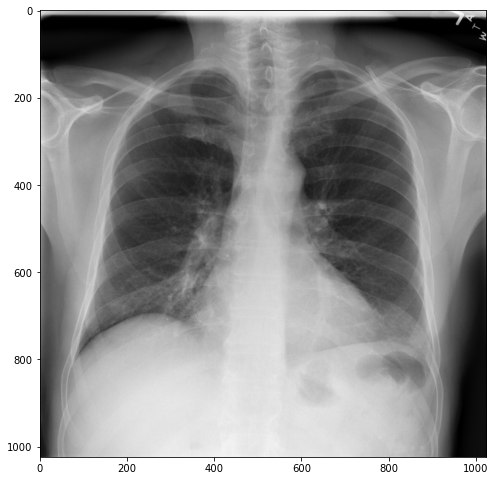

In [33]:
showImage(loadImage(file_map[list(file_map.keys())[100]]))

In [34]:
classes = [
    'Atelectasis', 
    'Consolidation', 
    'Infiltration', 
    'Pneumothorax', 
    'Edema', 
    'Emphysema', 
    'Fibrosis', 
    'Effusion', 
    'Pneumonia', 
    'Pleural_thickening', 
    'Cardiomegaly', 
    'Nodule', 
    'Mass', 
    'Hernia', 
    'No Finding'
]

In [35]:
class ImageDataset(Dataset):
    def __init__(self, data, transforms):
        self.image_paths = [file_map[f] for f in data[0]]
        self.labels = data[1]
        self.transforms = transforms
        
    def __len__(self):
        return len(data[0])
    
    def __getitem__(self, idx):
        image = self.transforms(loadImage(self.image_paths[idx]))
        target = torch.tensor([int(cls in self.labels[idx]) for cls in classes], dtype=torch.float32)
        return (image, target)

In [36]:
data = (df.iloc[:5000, 0], [df.iloc[i, 1].split('|') for i in range(5000)])

In [37]:
dataset = ImageDataset(data, trns.Compose([
    trns.Resize((240, 240)),
    trns.ToTensor(), 
    trns.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],inplace=True)
]))

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


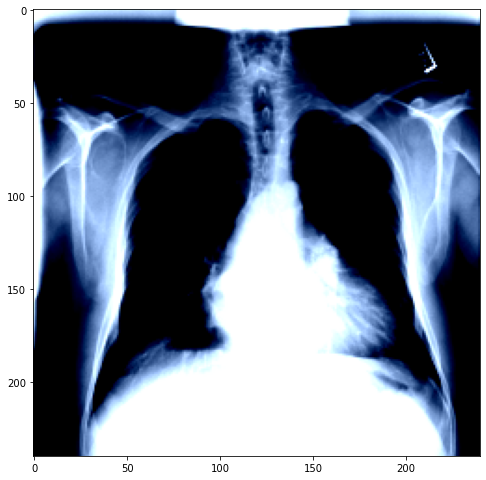

In [38]:
print(dataset[1][1])
plt.imshow(dataset[1][0].permute((1, 2, 0)))

## Define training and validation sets

In [39]:
train_dataset, validation_dataset = random_split(dataset, [int(len(dataset) * 0.85), 
            len(dataset) - int(len(dataset) * 0.85)])

In [40]:
train_dataset_size = len(train_dataset)
validation_dataset_size = len(validation_dataset)

train_dataset_size, validation_dataset_size

(4250, 750)

## Define notebook constants

In [41]:
num_classes = 15
input_shape = (3, 240, 240)

In [42]:
num_clients = 3
rounds = 10
batch_size = 64
epochs_per_client = 6
learning_rate = 1e-1

In [43]:
resnet34 = models.resnet34(pretrained=True)
resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Define GPU utilities

In [44]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

## Define FederatedNet class

In [45]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        self.network.fc = torch.nn.Linear(self.network.fc.in_features, num_classes)
        self.track_layers = {
            'layer4':  self.network.layer4,
            'linear': self.network.fc
        }
        self.freeze()

    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad = False
        for layer_name in self.track_layers:
            for param in self.track_layers[layer_name].parameters():
                param.requires_grad = True
    
    def forward(self, x_batch):
        out = torch.sigmoid(self.network(x_batch))
        return out
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                layer_params = list(self.track_layers[layer_name].parameters())
                for i in range(len(layer_params)):
                    layer_params[i].data = (layer_params[i].data + (parameters_dict[layer_name][i] - 
                                                layer_params[i].data))
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = [param.data.clone().detach() for param in self.track_layers
                                                [layer_name].parameters()]
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            return torch.tensor(torch.sum((outputs > 0.5) == labels).item() / len(outputs))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.binary_cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        self.train()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=64):
        self.eval()
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

## Define Client class

In [46]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict, return_model_dict=False):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print(self.client_id + ':')
        for i, res in enumerate(train_history):
            print('Epoch [{}]: Loss = {}, Accuracy = {}'.format(i + 1, round(res[0], 4), round(res[1], 4)))
        return net.get_parameters(), net.state_dict() if return_model_dict else None

## Setup clients

In [47]:
examples_per_client = train_dataset_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client, 
           train_dataset_size) - i for i in range(0, train_dataset_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

## Start server

In [48]:
global_net = to_device(FederatedNet(), device)
history = []

for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, [0 for param in global_net.track_layers[layer_name].parameters()])
                            for layer_name in curr_parameters])
    for j, client in enumerate(clients):
        client_parameters, state_dict = client.train(curr_parameters, (j == len(clients) - 1))
        if j == len(clients) - 1:
            global_net.load_state_dict(state_dict)
            global_net.apply_parameters(client_parameters)
            train_loss, train_acc = global_net.evaluate(train_dataset)
            val_loss, val_acc = global_net.evaluate(validation_dataset)
            print('After round {}, train_loss = {}, val_loss = {}, val_acc = {}\n'.format(i + 1, round(train_loss, 4), 
                    round(val_loss, 4), round(val_acc, 4)))
            history.append((train_loss, val_loss))

        fraction = client.get_dataset_size() / train_dataset_size
        for layer_name in client_parameters:
            for j in range(len(client_parameters[layer_name])):
                new_parameters[layer_name][j] += fraction * client_parameters[layer_name][j]

    global_net.apply_parameters(new_parameters)

Start Round 1 ...
client_0:
Epoch [1]: Loss = 0.2421, Accuracy = 13.5734
Epoch [2]: Loss = 0.194, Accuracy = 13.9742
Epoch [3]: Loss = 0.1851, Accuracy = 14.0285
Epoch [4]: Loss = 0.1756, Accuracy = 14.0693
Epoch [5]: Loss = 0.172, Accuracy = 14.0659
Epoch [6]: Loss = 0.1666, Accuracy = 14.106
client_1:
Epoch [1]: Loss = 0.2486, Accuracy = 13.5346
Epoch [2]: Loss = 0.2001, Accuracy = 13.947
Epoch [3]: Loss = 0.19, Accuracy = 14.0075
Epoch [4]: Loss = 0.1834, Accuracy = 14.0292
Epoch [5]: Loss = 0.1769, Accuracy = 14.0516
Epoch [6]: Loss = 0.1692, Accuracy = 14.0958
client_2:
Epoch [1]: Loss = 0.243, Accuracy = 13.591
Epoch [2]: Loss = 0.1972, Accuracy = 13.9633
Epoch [3]: Loss = 0.1897, Accuracy = 14.017
Epoch [4]: Loss = 0.1824, Accuracy = 14.0482
Epoch [5]: Loss = 0.1726, Accuracy = 14.0897
Epoch [6]: Loss = 0.1642, Accuracy = 14.125
After round 1, train_loss = 0.185, val_loss = 0.1905, val_acc = 13.9922

Start Round 2 ...
client_0:
Epoch [1]: Loss = 0.1765, Accuracy = 14.0727
Epoch 

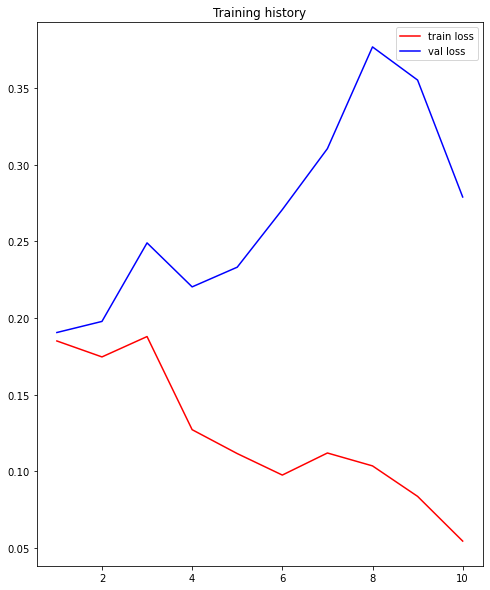

In [49]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='val loss')
plt.title('Training history')
plt.legend()
plt.show()